## Preface
***


**Customer Segmentation: A Principal Component Analysis and K-Means Clustering Approach** is my first major project on my journey to learn Data Science. This project served as my capstone after I completed a book titled Practical Linear Algebra by Mike Cohen (O'reilly Media). Although this project incorporates diverse concepts, its primary focus is on the implementation of Linear Algebra, including fundamental concepts like matrix multiplication as well as advanced concepts like Singular Value Decomposition (SVD), which extend to Principal Component Analysis (PCA). I hope this work serves as a foundation for more advanced projects in the future. Feedback and suggestions are always welcome.

My E-Mail: pbayu3783@gmail.com

Keywords: Linear Algebra, Principal Component Analysis, K-Mean Clustering, Customer Segmentation

# Introduction
***

**Background for The Project**

Customer segmentation involves dividing a customer base into distinct groups based on shared characteristics, such as demographics, behaviors, or preferences. This process enables businesses to tailor their marketing strategies, improve customer experiences, and enhance product offerings to meet the specific needs of each segment. By understanding these unique customer groups, companies can allocate resources more efficiently and increase overall profitability. (Forbes)


**Purpose and Expected Outcome**

This project aims to improve how businesses categorize their customers by leveraging data-driven techniques. Traditional segmentation methods often struggle with high-dimensional data, making it difficult to extract meaningful patterns. To address this, the project applies Principal Component Analysis (PCA) to reduce dimensionality and K-Means clustering to group customers with similar characteristics effectively. Additionally, this approach simplifies data analysis, reduces computation time, and offers a cost-effective solution for customer segmentation.

# Data Preprocessing
***

Before we analyze our data, we need to understand it. This includes examining the dataset, understanding what each column and row represent, and determining the necessary steps before analysis. In the data preprocessing stage, I will transform the data into a clean and usable format.

## Importing Dataset

This is a transactional dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. Source: https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
import pandas as pd  # type: ignore

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df_original = pd.read_excel(url)

Create a copy to avoid modifying original data. Also,
create a reporting mechanism to track all changes made to the dataset (opsional).

In [2]:
df = df_original.copy()
report = {}

## Cleaning the Data

The dataset consist of 8 features (column) and more than 540k obervations (rows). Here's the explanation for each features:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides. 

**Data Quality Check**

Checking the number of row & column, missing values, and duplicates

In [3]:
report["initial_shape"] = df.shape
# Checking the number of rows and column

report["missing_values"] = df.isnull().sum().to_dict()
# Checking the total of missing values

report["duplicates"] = len(df) - len(df.drop_duplicates())
# Checking the number of duplicate data

print(report)

{'initial_shape': (541909, 8), 'missing_values': {'InvoiceNo': 0, 'StockCode': 0, 'Description': 1454, 'Quantity': 0, 'InvoiceDate': 0, 'UnitPrice': 0, 'CustomerID': 135080, 'Country': 0}, 'duplicates': 5268}


**Data Cleaning**

There's a lot of missing values in CustomerID and description. Description feature isn't necessary for segmentation, so we're not gonna remove it but fill it with "unknown" string. For a missing values in CustomerID, we will remove it.

There's also a duplicate inside the dataset, we'll also remove it after we clean the missing data.

In [4]:
df = df.dropna(subset=["CustomerID"])  # Removing rows with missing customerID
df["Description"] = df["Description"].fillna("unknown")
# Filling the missing value with unknown string

report["removed_missing_customerid"] = report["initial_shape"][0] - len(df)
# Tracking the number of removed missing customerID

print(report["removed_missing_customerid"])  # The number of deleted row

135080


In [5]:
df = df.drop_duplicates()  # Removing the duplicates

report["removed_duplicates"] = (
    report["initial_shape"][0] - report["removed_missing_customerid"] - len(df)
)
# Tracking the number of removed duplicates

print(report["removed_duplicates"])

5225


Convert InvoiceDate to datetime format

In [6]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

Creating a new column that represent the cancellation of an invoice. It will show "True" if cancelled, removing the C in the invoiceNo, make the data more uniform.

In [7]:
df["is_cancelled"] = df["InvoiceNo"].astype(str).str.startswith("C")
# Cancellation distinction
df["InvoiceNo"] = df["InvoiceNo"].astype(str).str.replace("C", "")
# Removing C from InvoiceNo

Take a look at the "Quantity" and "Unit Price" features. We need to calculate the total transaction because it represents the true spending of a customer for each transaction.

In [8]:
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

After that, we're going to check and remove any invalid transaction. Invalid transaction is a data that doesn't make any sense. Probably from a human or system errors.

In [9]:
df = df[(df["UnitPrice"] > 0)]

# Any negative amount in that features doesn't make any sense. That's why we removed it.

report["removed_invalid_transactions"] = (
    report["initial_shape"][0]
    - report["removed_missing_customerid"]
    - report["removed_duplicates"]
    - len(df)
)

print(report["removed_invalid_transactions"])

40


## Customer Features

Customer features will create a new dataframe from our df. This function is usefull because it summarizes all of the rows in our df to build a profile for each customer. We do this because our analysis is focused on the customer segmentation from the transaction. Understanding the behaviour of each customer will help the machine to learn how to segment effectively. Here's the new feature that we're looking for:

- Recency: Days since the customer's last purchase.
- Frequency: Number of unique transactions.
- Monetary: Total amount spent.
- AvgBasketSize: Average quantity of items per transaction.
- AvgUnitPrice: Average price of purchased products.
- UniqueProducts: Number of unique products purchased.
- CancellationRate: Percentage of canceled transactions.

Recency, It'll help us identify active vs dormant customers. Also useful for predicting churn risk. Higher recency means lower engagement, indicating the need for reengagement srategy.

In [10]:
last_purchase_date = df.groupby("CustomerID")["InvoiceDate"].max()
# Will group the dataframe by customer then return the max amount (latest)

recent_date = df["InvoiceDate"].max()
# Return the latest transaction in all of the data

recency = (recent_date - last_purchase_date).dt.days
# Return the number of days from the latest purchase date for each customer

Frequency, It'll help us measure customer loyalty and engagement level. High-frequency often result in repeat buyers. Could be use to promote VIP and loyalty rewards. 

In [11]:
frequency = df.groupby("CustomerID")["InvoiceNo"].nunique()
# Will group the dataframe by customer then return the number of unique invoice (number of transaction)

Monetary, or total amount spent will show customer value to the business. It'll help us differentiate between high-spending vs low-spending customers. We can use this data to tier customer segmentation (premium vs regular shoppers etc.)

In [12]:
monetary = df.groupby("CustomerID")["TotalAmount"].sum()
monetary = monetary[monetary > 0]
# Will group the dataframe by customer then return the total spending on all of its transaction
# Will filter any negative value because it doesn't make any sense

Additional featuers that could be considered:

Average Basket Size, is a measure to indicates a bulk or small order behaviour. Could be used to create upselling and bundling strategies

Average Unit Price, will help classify whether customers is a premium buyer or price sensitive

Unique Products, measure customer diversity in product interest

Cancellation Rate, highlight customer dissastifaction or order issues. Excessive return could let to a potential fraudulent behaviour


In [13]:
avg_basket_size = df.groupby("CustomerID")["Quantity"].mean()
# Will group the dataframe by customer then return the average quantity of product sold

avg_unit_price = df.groupby("CustomerID")["UnitPrice"].mean()
# Will group the dataframe by customer then return the average price per product sold

total_unique_product = df.groupby("CustomerID")["StockCode"].nunique()
# Will group the dataframe by customer then return the number of unique product

cancellation_rate = df.groupby("CustomerID")["is_cancelled"].mean()
# Will group the dataframe by customer then return the rate of cancelled order


Combining all feature into one dataframe

In [14]:
customer_features = pd.DataFrame(
    {
        "Recency": recency,
        "Frequency": frequency,
        "Monetary": monetary,
        "AvgBasketSize": avg_basket_size,
        "AvgUnitPrice": avg_unit_price,
        "UniqueProduct": total_unique_product,
        "CancellationRate": cancellation_rate,
    }
)

Generating Final Report After Preprocessing

In [15]:
report["final_shape"] = df.shape
# final df rows and columns

report["unique_customers"] = len(customer_features)
# The number of customers

report["date_range"] = {
    "start": df["InvoiceDate"].min(),
    "end": df["InvoiceDate"].max(),
}

## Data Transformation

Transformation is one of the method used to prepare for analysis. It'll prevent outliers from distorting the clustering result. We're going to use a transformation and strandardization for this analysis.

**Distribution Plot**

This plot will help us understand the feature distribution and detect outliers visually. It could also help us decide what kind of transformation we want to choose. Plot the histogram for each feature



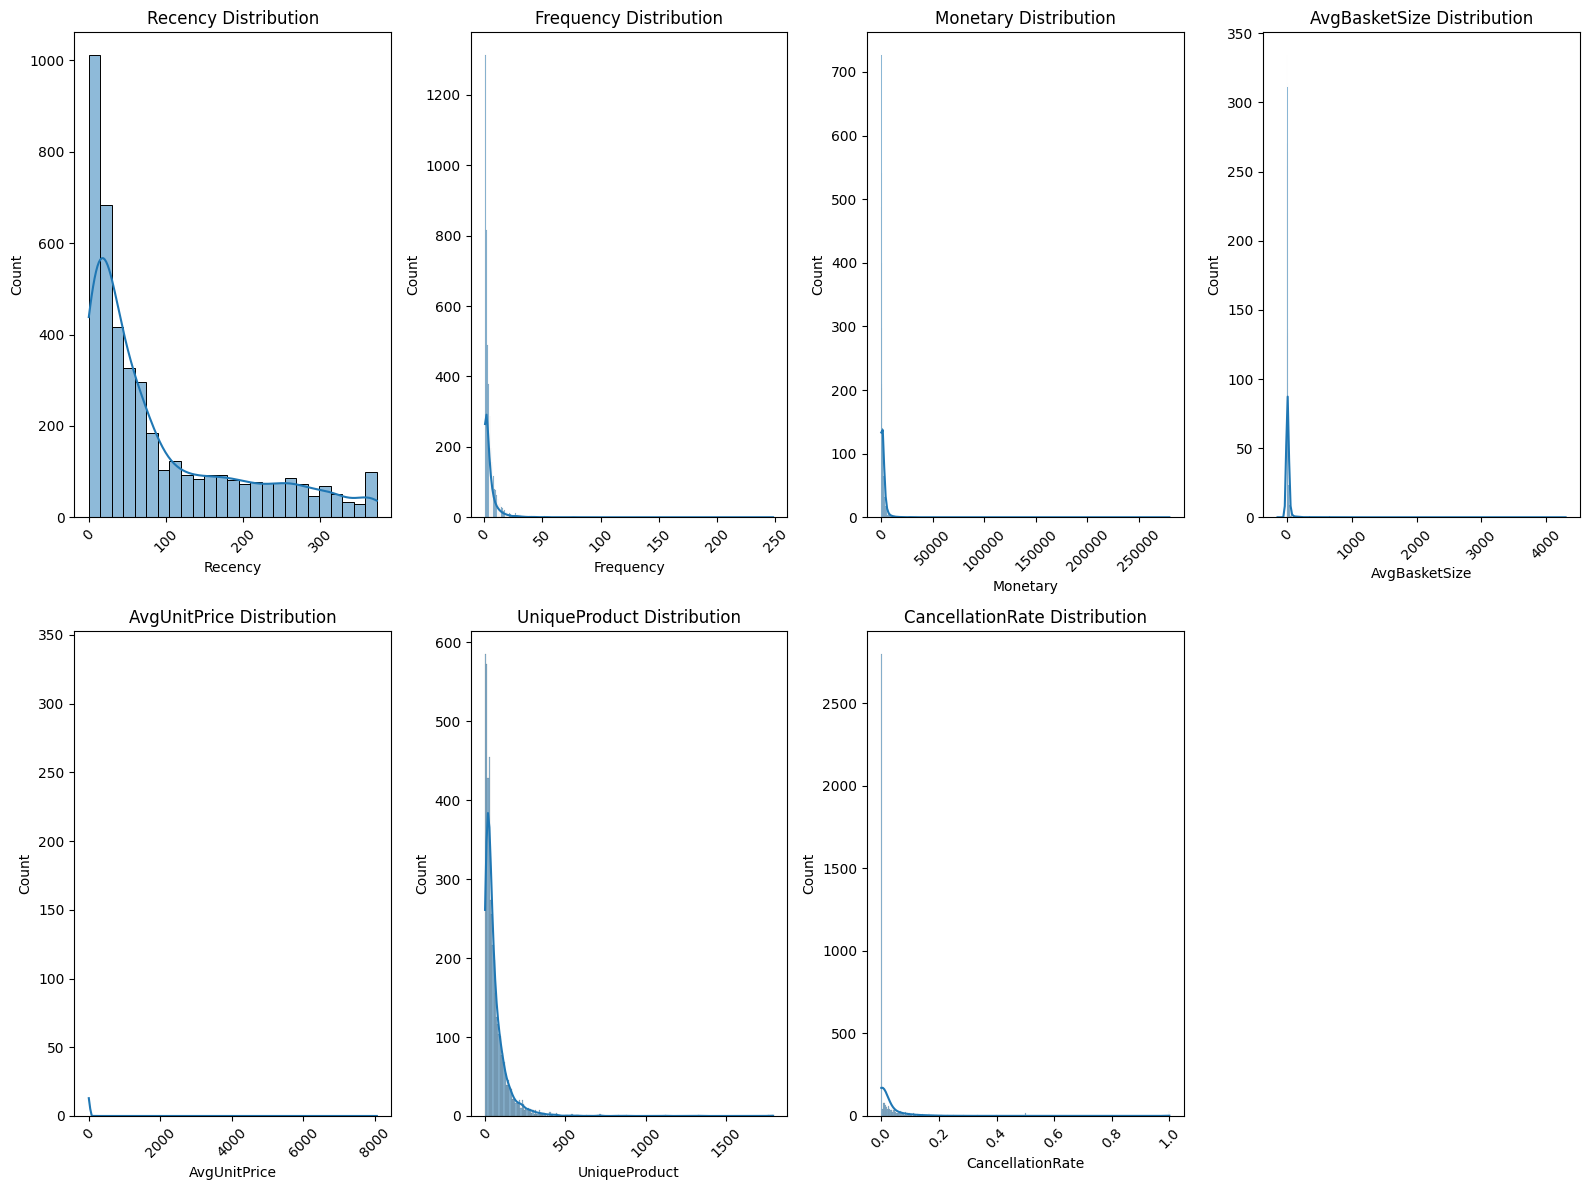

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# Library for visualization

plt.figure(figsize=(16, 12))
# Plot will be 16x12 inches

for i, column in enumerate(customer_features.columns, 1):
    # Loop start counting from customer_features column from 1 until the end
    plt.subplot(2, 4, i)
    # Creating a subplot grid with 2 rows, 4 columns, i will determine the position
    sns.histplot(customer_features[column], kde=True)
    # Plots a histogram with Kernel Density Function (KDE)
    plt.title(f"{column} Distribution")
    # Title for each subplot
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    # Rotation of ticks just for better readability

plt.tight_layout()
plt.show()

From the histogram showed, here are the key issued and recommended actions:

- Extreme right skewness: Frequency, Monetary, AverageBasketSize, AvgUnitPrice.
We need to apply log transformation (log1p) to these features
- Recency distribution has less severe right skew but we will proceed to transform it with log1p
- For outliers, we need to check extreme values and remove it from the dataset

**Matrix Correlation Plot**

It's a table that shows relationship between numerical variables in my dataset. It'll help identify how strongly the relation between variable. The correlation will range between -1 and 1. With the larger number representing the higher the correlation. Highly correlated features contain redundant information. PCA removes this redundancy by transforming features into uncorrelated principal components. Also, strongly correlated features can distort clustering since K-Means uses Euclidean distance.

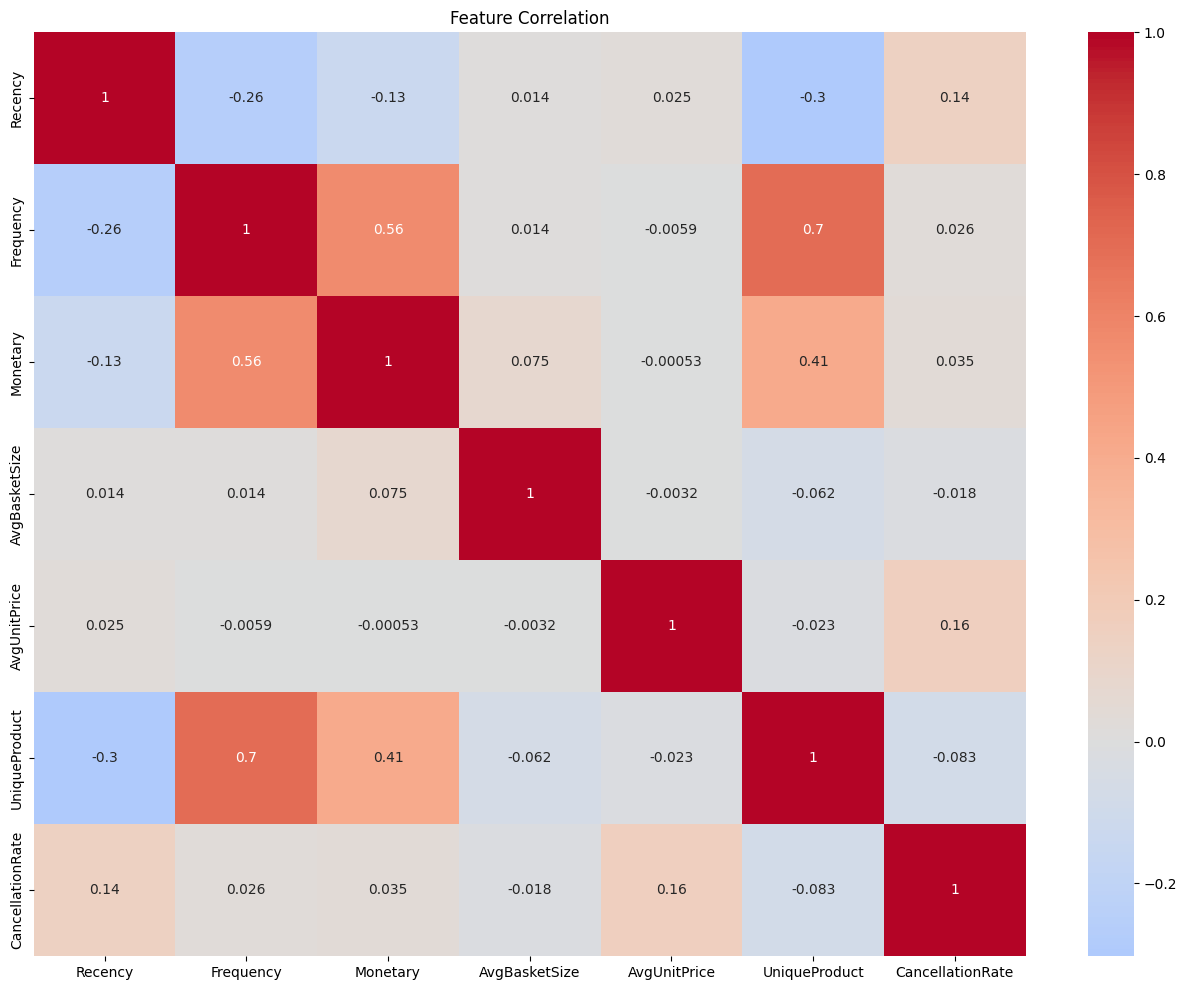

In [17]:
plt.figure(figsize=(16, 12))
# 16x12 inches plot

sns.heatmap(customer_features.corr(), annot=True, cmap="coolwarm", center=0)
# it will create heatmap based on the correlation number.

plt.title("Feature Correlation")

plt.show()

From the correlation matrix, here the key insights:

- Strong positive correlation for Frequency and monetary, frequency and unique products, monetary and unique product
- Negative correlation for recency and frequency, recency and unique product
- Very weak correaltion on Avg unit price and CancelationRate

**Data Transformation**

Based on the insights gain from the histogram and correlation matrix. Here's what we're gonna do:

1. Removes top 1% outliers (Monetary, AvgBasketSize, AvgUnitPrice)
2. Log-transforms skewed features (Everything except cacellation rate)
3. Preserves business-relevant outliers while removing extreme anomalies (UniqueProduct)

Removing outliers from Monetary, AvgBasketSize, and AvgUnitPrice

In [18]:
monetary_threshold = customer_features["Monetary"].quantile(0.99)
basket_threshold = customer_features["AvgBasketSize"].quantile(0.99)
price_threshold = customer_features["AvgUnitPrice"].quantile(0.99)
cancellation_threshold = customer_features["CancellationRate"].quantile(0.99)
# Creating a threshold for cutting 1% of the data

clean_features = customer_features[
    (customer_features["Monetary"] <= monetary_threshold)
    & (customer_features["AvgBasketSize"] <= basket_threshold)
    & (customer_features["AvgUnitPrice"] <= price_threshold)
    & (customer_features["CancellationRate"] <= cancellation_threshold)
]  # Creating a new clean dataframe after removing outliers

Using log transform for a skewed feature. This transformation will reduce skewness of a data. The tail of distribution could get compressed, making it more symmetric and easier to model. 

In [19]:
import numpy as np

# Define skewed features (without CancellationRate)
skewed_features = [
    "Recency",
    "Frequency",
    "Monetary",
    "AvgBasketSize",
    "AvgUnitPrice",
    "UniqueProduct",
    "CancellationRate",
]

# 1. Convert features to float64 first
clean_features = clean_features.astype(
    {feature: "float64" for feature in skewed_features}
)

# 2. Apply log transformation
for feature in skewed_features:
    clean_features.loc[:, feature] = np.log1p(clean_features.loc[:, feature])

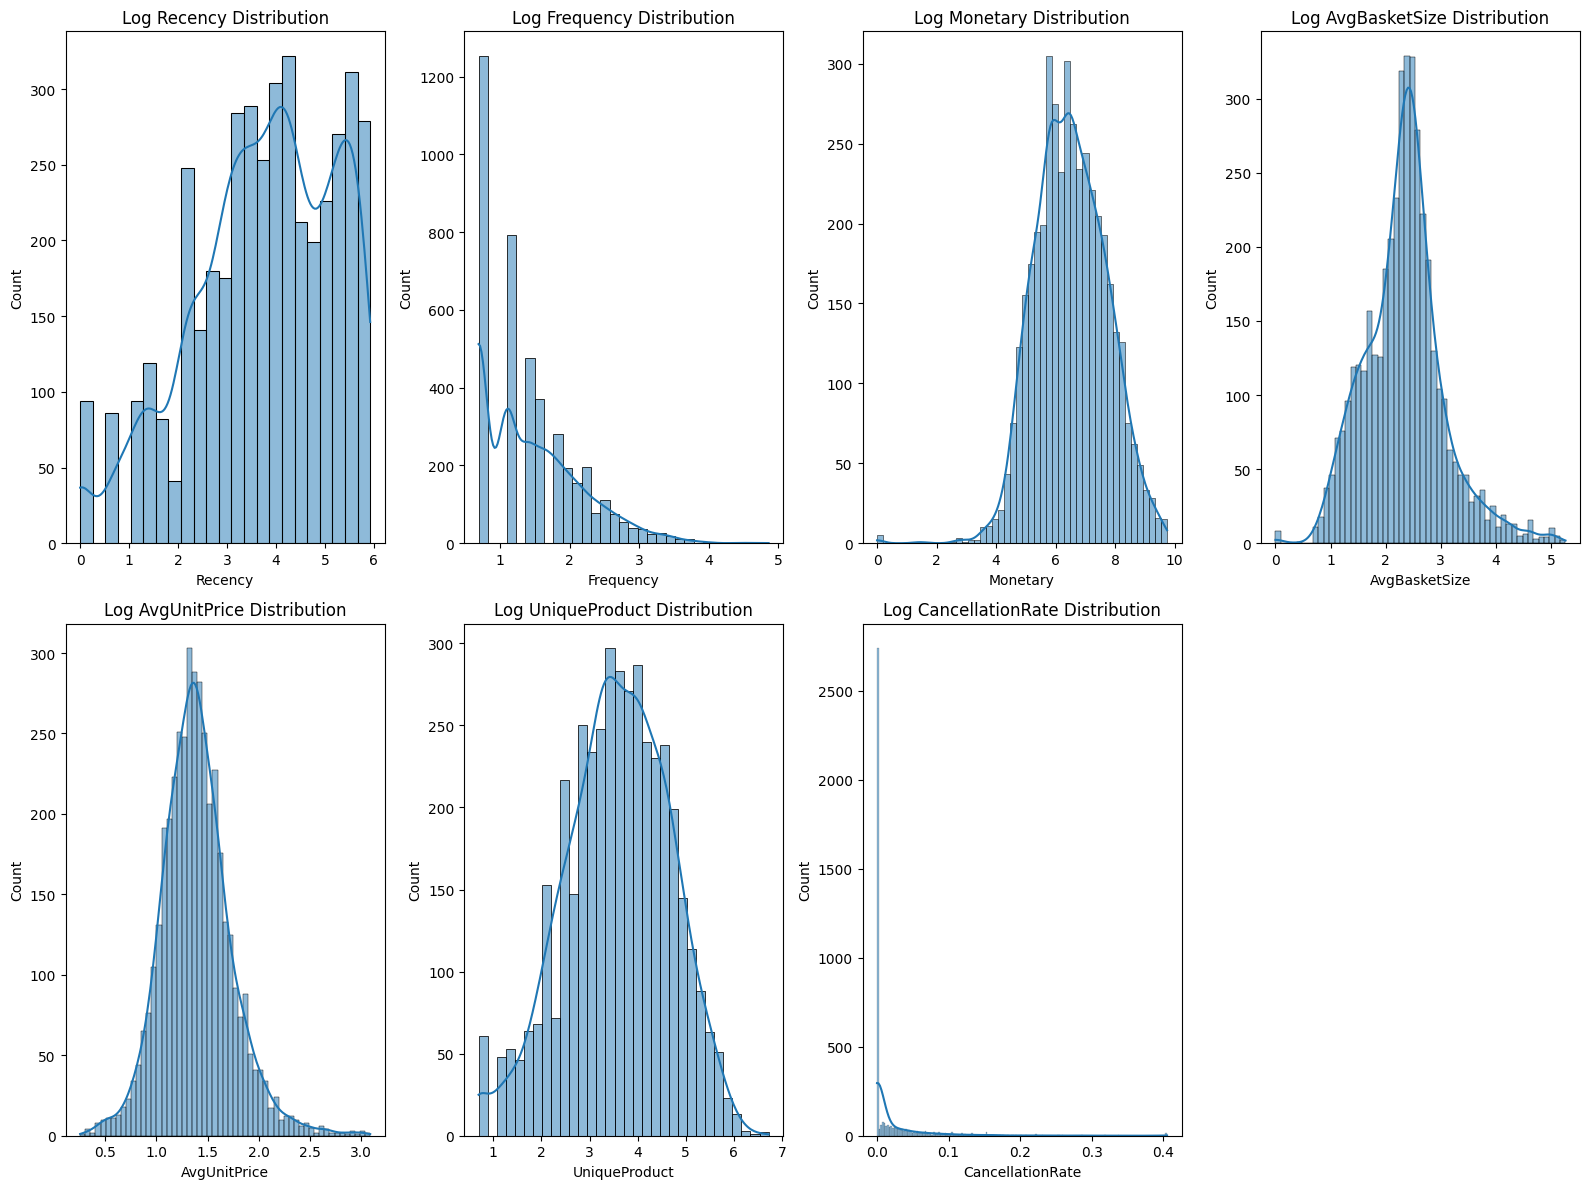

In [20]:
plt.figure(figsize=(16, 12))
# Plot will be 16x12 inches

for i, column in enumerate(clean_features.columns, 1):
    # Loop start counting from customer_features column from 1 until the end
    plt.subplot(2, 4, i)
    # Creating a subplot grid with 2 rows, 4 columns, i will determine the position
    sns.histplot(clean_features[column], kde=True)
    # Plots a histogram with Kernel Density Function (KDE)
    plt.title(f"Log {column} Distribution")
    # Title for each subplot
    plt.xlabel(column)
    plt.ylabel("Count")
    # Rotation of ticks just for better readability

plt.tight_layout()
plt.show()

**Feature Scaling**

Process of standardizing or normalizing numerical data so that all features have similar range or distribution. The standardization we're going to use is Z-score scaling.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_features)
scaled_features = pd.DataFrame(scaled_data, columns=clean_features.columns)

Correlation matrix for scaled features

<function matplotlib.pyplot.show(close=None, block=None)>

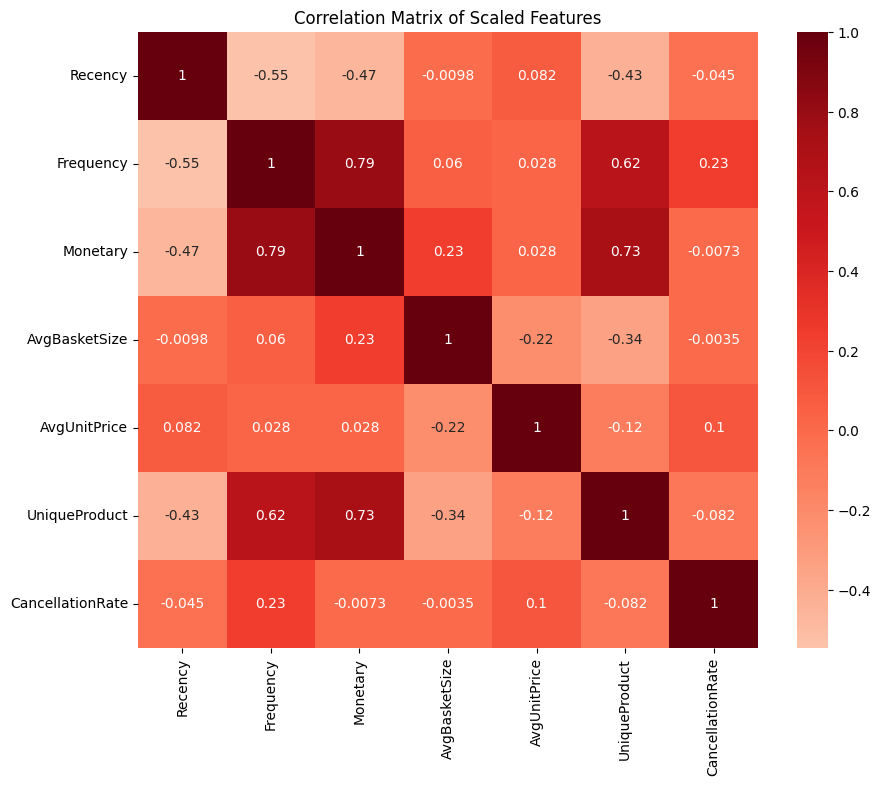

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_features.corr(), annot=True, cmap="Reds", center=0)
plt.title("Correlation Matrix of Scaled Features")
plt.show

In [23]:
# Before proceeding to PCA, verify the scaled CancellationRate still maintains the distinction between zero and non-zero values
scaled_cancellation = scaled_features["CancellationRate"]
print(
    "Proportion of near-zero values:",
    (
        scaled_cancellation
        < scaled_cancellation.mean() + 0.1 * scaled_cancellation.std()
    ).mean(),
)

Proportion of near-zero values: 0.7837966262770254


In [24]:
# Check how CancellationRate contributes to principal components
from sklearn.decomposition import PCA

pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Look at the loading of CancellationRate in each component
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i + 1}" for i in range(len(pca.components_))],
    index=clean_features.columns,
)
print("CancellationRate loadings:\n", loadings.loc["CancellationRate"])

CancellationRate loadings:
 PC1    0.052333
PC2   -0.126595
PC3    0.775536
PC4   -0.539960
PC5    0.151751
PC6   -0.255204
PC7    0.008015
Name: CancellationRate, dtype: float64


# Principal Component Analysis

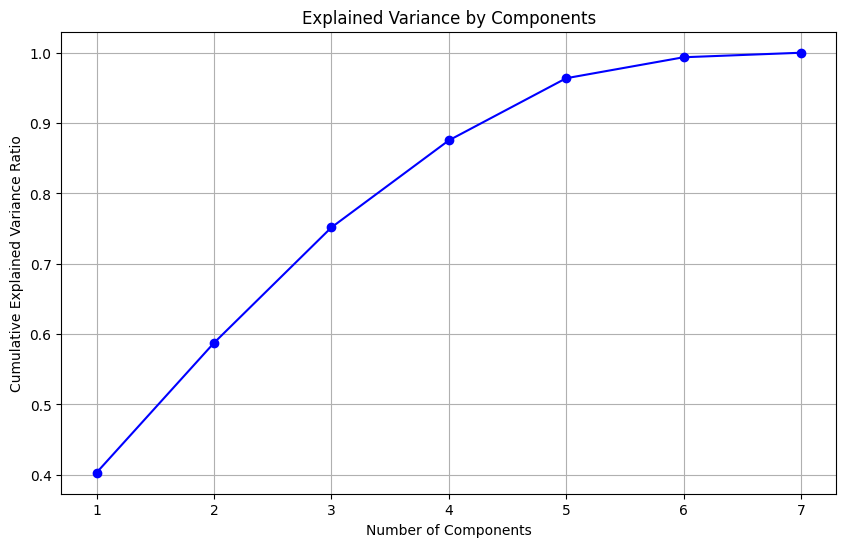

In [25]:
from sklearn.decomposition import PCA

pca = PCA()
pca_result = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, "bo-")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance by Components")
plt.grid(True)
plt.show()

In [26]:
pca4 = PCA(n_components=4)
pca_result4 = pca4.fit_transform(scaled_features)

component_loadings = pd.DataFrame(
    pca4.components_.T,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=clean_features.columns,
)

print(component_loadings)

                       PC1       PC2       PC3       PC4
Recency          -0.418105 -0.058330  0.001448  0.144445
Frequency         0.534324  0.005410  0.218241  0.013633
Monetary          0.537429  0.132737  0.036098  0.296444
AvgBasketSize     0.000171  0.782616  0.298818  0.327469
AvgUnitPrice     -0.031701 -0.549433  0.389729  0.692505
UniqueProduct     0.497104 -0.220360 -0.329284 -0.112761
CancellationRate  0.052333 -0.126595  0.775536 -0.539960


# K-Means Clustering

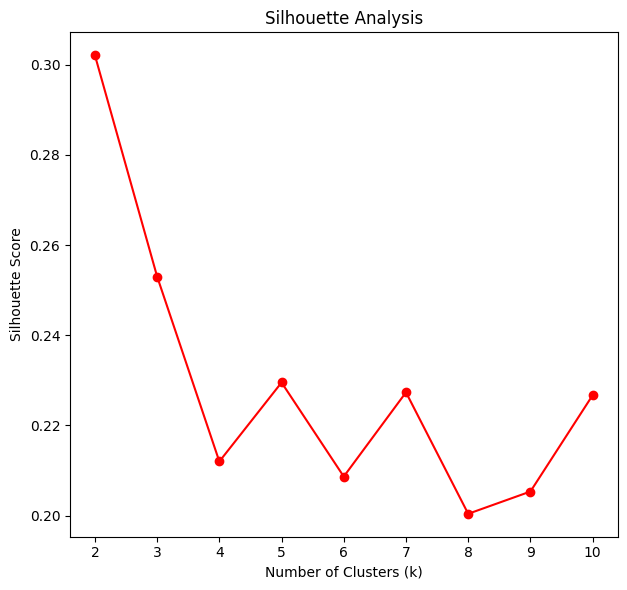

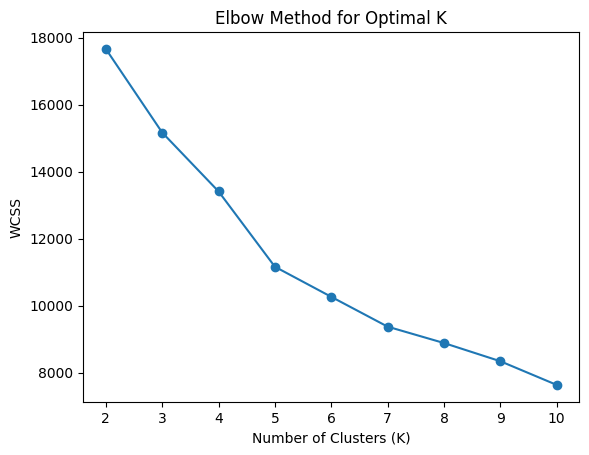

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
inertias = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(pca_result4)

    silhouette_scores.append(silhouette_score(pca_result4, clusters))
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), silhouette_scores, "ro-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.tight_layout()
plt.show()

plt.plot(range(2, 11), inertias, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")

plt.show()

/nCluster Profiles: 
           Recency  Frequency  Monetary  AvgBasketSize  AvgUnitPrice  \
Clusters                                                               
0         4.439209   1.018830  5.804743       1.918366      1.567134   
1         4.280394   0.994759  5.851644       3.024434      1.122756   
2         2.673189   2.105480  7.628722       2.347851      1.379474   

          UniqueProduct  CancellationRate  
Clusters                                   
0              3.231350          0.019490  
1              2.619430          0.015961  
2              4.500224          0.024645  


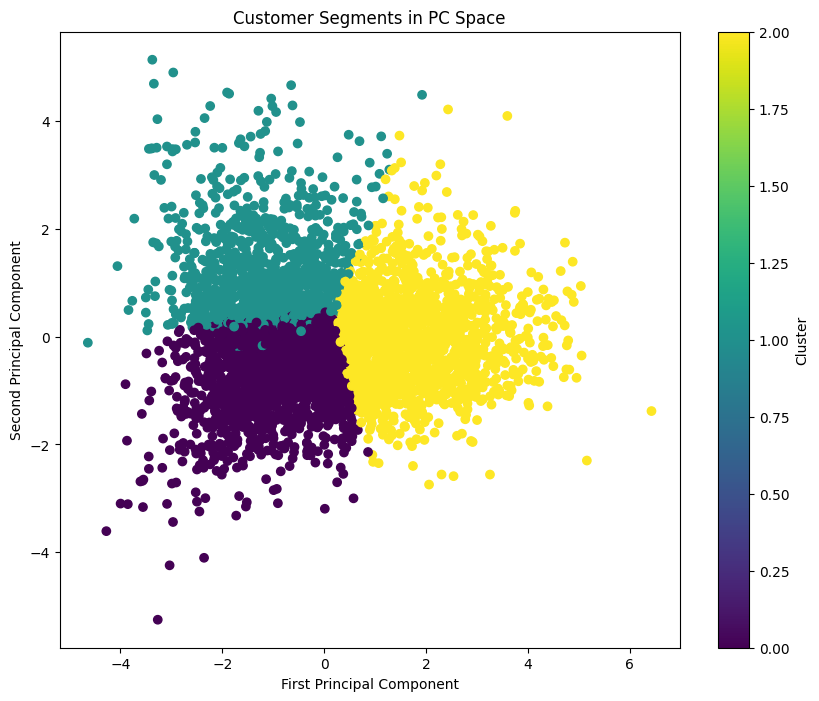

In [28]:
optimal_k = 3
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(pca_result4)

customer_segments = pd.DataFrame(clean_features)
customer_segments["Clusters"] = cluster_labels

cluster_profiles = customer_segments.groupby("Clusters").mean()
print("/nCluster Profiles: ")
print(cluster_profiles)

# Visualize clusters in PC space
plt.figure(figsize=(10, 8))
plt.scatter(pca_result4[:, 0], pca_result4[:, 1], c=cluster_labels, cmap="viridis")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Customer Segments in PC Space")
plt.colorbar(label="Cluster")
plt.show()

# Cluster Analysis and Interpretation

# Conclusion

# Reference

Forbes Advisor. (n.d.). Customer Segmentation: The Ultimate Guide. Retrieved from https://www.forbes.com/advisor/business/customer-segmentation/
